# TCLEAN with a mask

Note: this notebook will only work in python3.8 with CASA installed

In [5]:
print("TEST - just to make sure the notebook is live")

TEST - just to make sure the notebook is live


In [6]:
from ipywidgets import Button
Button(description='test')

Button(description='test', style=ButtonStyle())

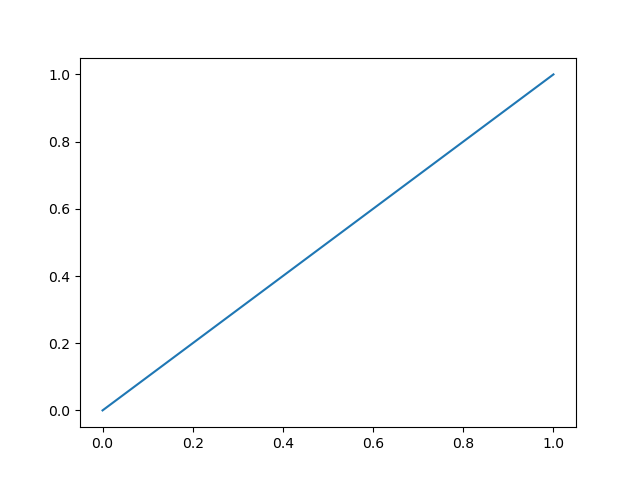

In [7]:
# test cell - if this doesn't make an interactive plot, your notebook environment is not going to work
%matplotlib widget
import pylab as pl
pl.plot([0,1])

In [8]:
cd /orange/adamginsburg/w51/vla/19A-254/example_clean

/orange/adamginsburg/w51/vla/19A-254/example_clean


PixCoord(x=1988.765443611071, y=1998.4064305097074)


Output()

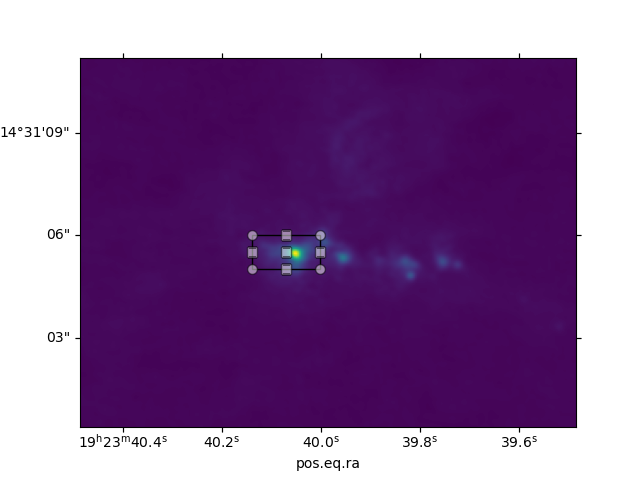

In [54]:
from astropy.io import fits
from astropy import wcs
import regions
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
from ipywidgets.widgets import Output
from ipywidgets import widgets

from ipywidgets import HBox, Label

pl.close('all')
    
hdu = fits.open("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/8QJT3K/WKXG0H")


with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    ww = wcs.WCS(hdu[0].header)
    pixscale = wcs.utils.proj_plane_pixel_scales(ww).mean()*u.deg
    center = SkyCoord('19:23:40.07', '14:31:05.5', frame='fk5', unit=(u.h, u.deg))
    x,y = (ww.world_to_pixel(center))
    centerpix = regions.PixCoord(float(x), float(y))
    print(centerpix)
    
    regionlist = []
    
    reg = regions.RectanglePixelRegion(center=centerpix,
                                       height=(1*u.arcsec/pixscale).decompose().value,
                                       width=(2*u.arcsec/pixscale).decompose().value)
    
    regionlist.append(reg)
    

    
    fig = pl.figure()
    ax = pl.subplot(projection=ww)
    ax.imshow(hdu[0].data)
    selector = reg.as_mpl_selector(ax)
    ax.axis((1867.9675324675327, 2158.8766233766237, 1896.2272727272727, 2112.3311688311687))
    
    button = widgets.Button(description="Save region")
    create_region_button = widgets.Button(description="Create region")

    output = widgets.Output()

    
    def add_region(b, ax=ax):
        x1,x2,y1,y2=ax.axis()
        for rr in regionlist:
            if hasattr(rr, '_mpl_selector'):
                rr._mpl_selector.set_active(False)
        newreg = regions.RectanglePixelRegion(regions.PixCoord((x1+x2)/2, (y1+y2)/2),
                                              width=15, height=10)
        #with output:
        #    print(newreg)
        selector = newreg.as_mpl_selector(ax)
        regionlist.append(newreg)
        with output:
            region_dropdown.options = region_dropdown.options + (newreg,)
        return newreg, selector
                                                               

    def on_button_clicked(b, reg=reg):
        with output:
            print(reg, reg.to_sky(ax.wcs))
        reg.to_sky(ax.wcs).write('test.crtf', format='crtf')
        with open('test.crtf', 'r') as fh:
            print(fh.read())

    button.on_click(on_button_clicked)
    create_region_button.on_click(add_region)
    region_dropdown = widgets.Dropdown(options=regionlist)
    def on_change(change):
        region_dropdown.options = regionlist
        #with output:
        #    print(change)
        if change['type'] == 'change' and change['name'] == 'value':
            print("changed to %s" % change['new'])
        if hasattr(change['new'], '_mpl_selector'):
            for rr in regionlist:
                rr._mpl_selector.set_active(False)
            rr = change['new']
            rr._mpl_selector.set_active(True)

    region_dropdown.observe(on_change)
    
    run_tclean = widgets.Button(description="Run tclean")
    def on_tclean_click(b):
        with output:
            print(f"Running tclean with niter={int(niter.value)}... and mask='test.crtf' (not really)")
    run_tclean.on_click(on_tclean_click)
    
    niter = widgets.Text(description="niter", value="100")
    

    display(HBox([button, create_region_button, region_dropdown, run_tclean, niter]), output)

In [13]:
import casatools
import casatasks

In [14]:
import regions
from astropy import units as u

In [16]:
from spectral_cube import SpectralCube
import numpy as np

In [18]:
%matplotlib widget
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
from astropy import visualization
visualization.quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b592b15d7c0>

In [ ]:
from casatasks import tclean

# Interactive tclean example

In [59]:
cd /orange/adamginsburg/w51/vla/19A-254/example_clean

/orange/adamginsburg/w51/vla/19A-254/example_clean


In [60]:
import casatools
import casatasks

In [61]:
import regions
from astropy import units as u

In [62]:
from spectral_cube import SpectralCube
import numpy as np

In [63]:
%matplotlib widget
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
from astropy import visualization
visualization.quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b58758f0dc0>

In [64]:
basepath = '/orange/adamginsburg/w51/vla/19A-254/derod/'
default_tclean_args = dict(vis=[f'{basepath}/19A-254_2019_08_12_T06_24_59.084/19A-254.sb36820841.eb37052030.58707.15631115741.ms', 
            f'{basepath}/19A-254_2019_08_18_T07_49_02.741/19A-254.sb36871654.eb37083330.58713.148749155094.ms',
            f'{basepath}/19A-254_2019_08_02_T15_20_05.733/19A-254.sb36820841.eb37001660.58697.18583002315.ms'],
       #imagename='example_masked_clean',
       field='W51 North',
       spw='56',
       restfreq="19.758046GHz",
       imsize=800, cell="0.014arcsec",
       start='19.753814GHz',
       nchan=3, # only image a few channels to make this quick
       mask='',
       threshold='5mJy',
       specmode='cube')

In [66]:
# make dirty image
casatasks.tclean(imagename='dirty', niter=0, **default_tclean_args)

{}

In [ ]:
from astropy.io import fits
from astropy import wcs
import regions
from astropy.coordinates import SkyCoord
from astropy import units as u
import warnings
from ipywidgets.widgets import Output
from ipywidgets import widgets

from ipywidgets import HBox, Label

pl.close('all')
    


with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    
    dirty_image = SpectralCube.read('dirty.residual', format='casa_image')
    ww = dirty_image.wcs.celestial

    
    regionlist = []
    centerpix = regions.PixCoord(dirty_image.shape[2]/2, dirty_image.shape[1]/2)
    reg = regions.RectanglePixelRegion(center=centerpix,
                                       height=10,
                                       width=15)
    
    regionlist.append(reg)
    

    
    fig = pl.figure()
    ax = pl.subplot(projection=ww)
    ax.imshow(dirty_image[0].value)
    selector = reg.as_mpl_selector(ax)
    
    button = widgets.Button(description="Save region")
    create_region_button = widgets.Button(description="Create region")

    output = widgets.Output()

    
    def add_region(b, ax=ax):
        x1,x2,y1,y2=ax.axis()
        for rr in regionlist:
            if hasattr(rr, '_mpl_selector'):
                rr._mpl_selector.set_active(False)
        newreg = regions.RectanglePixelRegion(regions.PixCoord((x1+x2)/2, (y1+y2)/2),
                                              width=15, height=10)
        #with output:
        #    print(newreg)
        selector = newreg.as_mpl_selector(ax)
        regionlist.append(newreg)
        with output:
            region_dropdown.options = region_dropdown.options + (newreg,)
        return newreg, selector
                                                               

    def on_button_clicked(b, reg=reg):
        with output:
            print(reg, reg.to_sky(ax.wcs))
        reg.to_sky(ax.wcs).write('test.crtf', format='crtf')
        with open('test.crtf', 'r') as fh:
            print(fh.read())

    button.on_click(on_button_clicked)
    create_region_button.on_click(add_region)
    region_dropdown = widgets.Dropdown(options=regionlist)
    def on_change(change):
        region_dropdown.options = regionlist
        #with output:
        #    print(change)
        if change['type'] == 'change' and change['name'] == 'value':
            print("changed to %s" % change['new'])
        if hasattr(change['new'], '_mpl_selector'):
            for rr in regionlist:
                rr._mpl_selector.set_active(False)
            rr = change['new']
            rr._mpl_selector.set_active(True)

    region_dropdown.observe(on_change)
    
    run_tclean = widgets.Button(description="Run tclean")
    def on_tclean_click(b):
        with output:
            casatasks.tclean(imagename='clean', niter=int(niter.value),
                             **default_tclean_args)
        clean_resid = SpectralCube.read('clean.residual', format='casa_image')
        ax.imshow(clean_resid[0].value)
        with output:
            print(f"Done tcleaning with {niter.value} iterations")
    run_tclean.on_click(on_tclean_click)
    
    niter = widgets.Text(description="niter", value="100")
    

    display(HBox([button, create_region_button, region_dropdown, run_tclean, niter]), output)

In [ ]:
default_tclean_args